In [4]:
import torch
import numpy as np
from scipy.signal import welch
from sbi import utils as sbi_utils
from sbi.inference import SNPE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Load your trained generator and posterior (already done)
from tensorflow.keras.models import load_model
generator = load_model("saved_models/qpo_cgan_phy_generator.keras")

# Load pre-trained SBI posterior (already trained)
# Assume: posterior = inference.build_posterior(density_estimator)

posterior = torch.load("trained_sbi_posterior.pt")


/var/folders/15/7vdcd9756072lbp614rqt18c0000gn/T/ipykernel_4488/187271608.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior = torch.load("trained_sbi_posterior.

In [5]:
def generate_sbi_training_data_with_std(num_simulations=2000, latent_dim=100):
    X, y = [], []

    for _ in range(num_simulations // 2):
        # === QPO Sample ===
        fc = np.random.uniform(0.01, 1.0)
        amp = np.random.uniform(0.6, 1.0)
        label = np.array([[fc, amp, 1.0]], dtype=np.float32)
        z = np.random.randn(1, latent_dim)
        generated = generator([z, label], training=False).numpy().squeeze()
        f, Pxx = welch(generated, fs=1, nperseg=256)
        x = torch.tensor(Pxx, dtype=torch.float32)
        samples = posterior.sample((500,), x=x, show_progress_bars=False)
        fc_mean = samples[:, 0].mean().item()
        amp_mean = samples[:, 1].mean().item()
        fc_std = samples[:, 0].std().item()
        X.append([fc_mean, amp_mean, fc_std])
        y.append(1)

        # === Non-QPO Sample ===
        label = np.array([[fc, amp, 0.0]], dtype=np.float32)
        z = np.random.randn(1, latent_dim)
        generated = generator([z, label], training=False).numpy().squeeze()
        f, Pxx = welch(generated, fs=1, nperseg=256)
        x = torch.tensor(Pxx, dtype=torch.float32)
        samples = posterior.sample((500,), x=x, show_progress_bars=False)
        fc_mean = samples[:, 0].mean().item()
        amp_mean = samples[:, 1].mean().item()
        fc_std = samples[:, 0].std().item()
        X.append([fc_mean, amp_mean, fc_std])
        y.append(0)

    return np.array(X), np.array(y)

In [6]:
from sklearn.ensemble import RandomForestClassifier

def train_qpo_classifier_with_std(X, y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    return clf

# Call once
X_train, y_train = generate_sbi_training_data_with_std()
clf = train_qpo_classifier_with_std(X_train, y_train)


In [7]:
def detect_qpo_from_real_band_std(curve, posterior, clf):
    f, Pxx = welch(curve.squeeze(), fs=1, nperseg=256)
    x_obs = torch.tensor(Pxx, dtype=torch.float32)
    samples = posterior.sample((500,), x=x_obs)

    fc_mean = samples[:, 0].mean().item()
    amp_mean = samples[:, 1].mean().item()
    fc_std = samples[:, 0].std().item()

    qpo_label = clf.predict([[fc_mean, amp_mean, fc_std]])[0]

    return {
        "fc_mean": fc_mean,
        "fc_std": fc_std,
        "amp_mean": amp_mean,
        "qpo": bool(qpo_label),
        "samples": samples
    }



🎧 Band 1 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ fc_mean: 0.524, fc_std: 0.247
→ amp_mean: 0.549
→ QPO Detected? ✅ YES


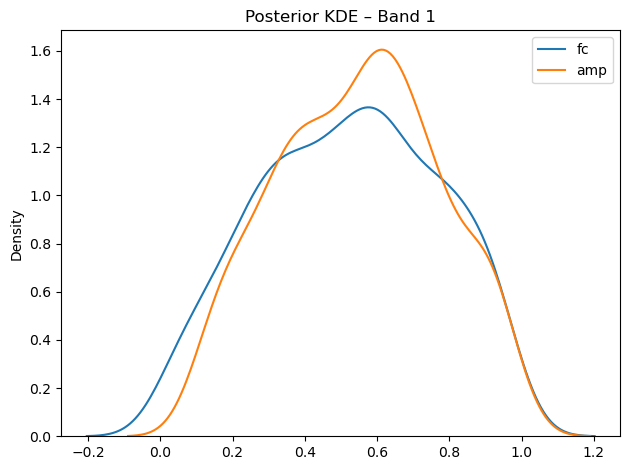


🎧 Band 2 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ fc_mean: 0.521, fc_std: 0.236
→ amp_mean: 0.565
→ QPO Detected? ✅ YES


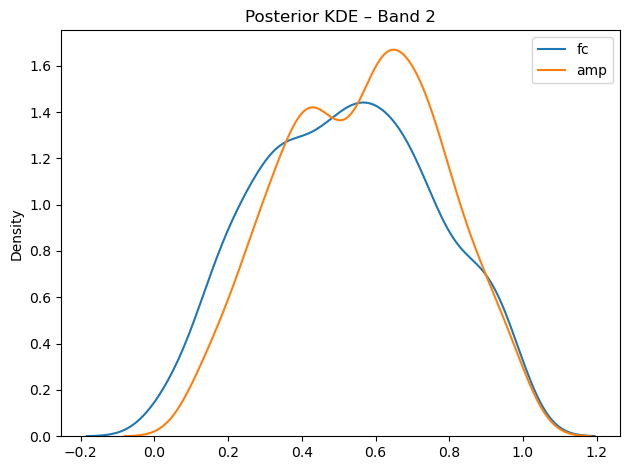


🎧 Band 3 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ fc_mean: 0.522, fc_std: 0.246
→ amp_mean: 0.546
→ QPO Detected? ✅ YES


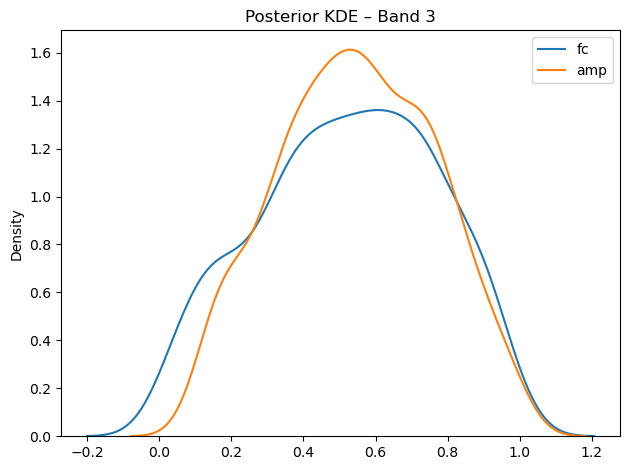


🎧 Band 4 Inference:


Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

→ fc_mean: 0.505, fc_std: 0.240
→ amp_mean: 0.563
→ QPO Detected? ✅ YES


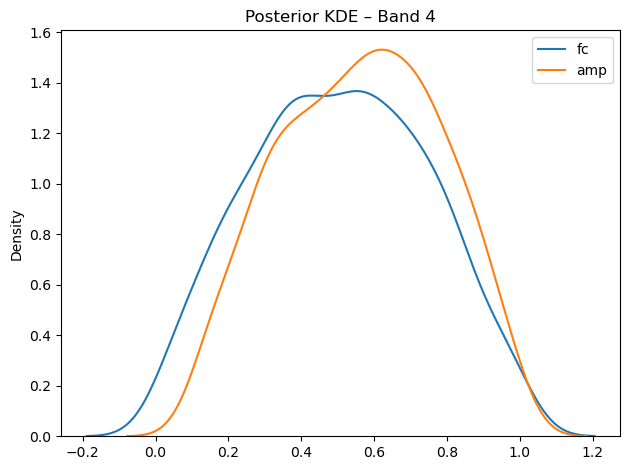

In [8]:
data = np.loadtxt("ltcrv4bands_rej_dt100.dat")
bands = [data[:, i] for i in range(4)]

for i, band in enumerate(bands):
    print(f"\n🎧 Band {i+1} Inference:")
    result = detect_qpo_from_real_band_std(band, posterior, clf)
    print(f"→ fc_mean: {result['fc_mean']:.3f}, fc_std: {result['fc_std']:.3f}")
    print(f"→ amp_mean: {result['amp_mean']:.3f}")
    print(f"→ QPO Detected? {'✅ YES' if result['qpo'] else '❌ NO'}")

    # Optional: KDE plot
    import seaborn as sns
    sns.kdeplot(result['samples'][:, 0].numpy(), label="fc")
    sns.kdeplot(result['samples'][:, 1].numpy(), label="amp")
    plt.title(f"Posterior KDE – Band {i+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()
